

# World Happiness Report

This case study is based on the 7th World Happiness Report. The first was released in April 2012 in support of a UN High level meeting on “Wellbeing and Happiness: Defining a New Economic Paradigm”. 

That 2012 report presented the available global data on national happiness and reviewed related evidence from the emerging science of happiness, showing that the quality of people’s lives can be coherently, reliably, and validly assessed by a variety of subjective well-being measures, collectively referred to then and in subsequent reports as “happiness.” 

This year’s World Happiness Report focuses on happiness and the community: how happiness has evolved over the past dozen years, with a focus on the technologies, social norms, conflicts and government policies that have driven those changes.

The data is from [Chapter 2: Online Data](https://s3.amazonaws.com/happiness-report/2019/Chapter2OnlineData.xls) and filtered out data prior to 2018. The result is available in CSV format, as the next cell shows. _Data Prep Notes:_ The Happiness Score column is from Figure 2.6 in the downloaded report; the other data columns are from Table 2.1 in the same report. If a country wasn't in either list, it wasn't included in the CSV file.

In [1]:
import pandas as pd
data1 = pd.read_csv('happiness-report.csv')
data1

## Some observations:

* **Quality** Some data points, e.g., Generosity for Yemen are unavailable. This is typically done using `dropna()` as shown below.

* **Normalization:** The columns have different ranges: some values are between 0. and 1., Generosity is between -0.33 and 0.49, and so on. The data needs to be preprocessed so as to be uniform. The process of making all columns uniform in scale is referred to as **Feature Scaling**. Many data analysis libraries require it (see [_The Importance of Feature Scaling_](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)). Scikit-Learn offers an extensive library for [preprocessing data](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing). Pay particular attention to `*Scaler()` functions. Also Discretizers such as Binarizer, KBinsDiscretizer and QuantileTransformer.

* **Pre-normalization:** `LogGDP` is the logarithm of the GDP per capita. Here is a case where the data has gone through Feature Scaling _prior to publication!_ Taking a log of numbers whose range spans multiple orders of magnitude is a common technique for compressing the range. However, it still doesn't span the range [0. 1.] and a bit more Feature Scaling is required.

In [2]:
# Get a sense of data quality
data1_not_na = data1.dropna()
data1_good_or_na = pd.merge(data1, data1_not_na, indicator=True, how='left')
# _good_or_na has a new column '_merge' which has values 'left_only' or 'both'. Pick 'left_only'
data1_na = data1_good_or_na.query('_merge=="left_only"').drop('_merge', axis=1)
data1_na

,Country,Year,HappinessScore,LifeLadder,LogGDP,SocialSupport,HealthyLifeExpectancyAtBirth,FreedomToMakeLifeChoices,Generosity,PerceptionsOfCorruption,PositiveAffect,NegativeAffect,ConfidenceInNationalGovernment
2,Algeria,2018,5.211,5.043086,9.557952,0.798651,65.900002,0.583381,-0.172413,0.758704,0.591043,0.292946,NaN
18,Burundi,2018,3.775,3.775283,6.541033,0.484715,53.400002,0.646399,-0.019334,0.598608,0.666442,0.362767,NaN
19,Cambodia,2018,4.700,5.121838,8.253352,0.794605,61.599998,0.958305,0.033787,NaN,0.844593,0.414346,NaN
24,China,2018,5.191,5.131434,9.694376,0.787605,69.300003,0.895378,-0.174899,NaN,0.855784,0.189640,NaN
30,Cyprus,2018,6.046,6.276443,NaN,0.825573,73.699997,0.794215,NaN,0.848337,0.750122,0.298021,0.352440
35,Egypt,2018,4.166,4.005451,9.293960,0.758824,61.700001,0.681654,-0.222930,NaN,0.492261,0.285184,NaN
42,Gambia,2018,4.516,4.922099,7.376554,0.684800,55.000000,0.718729,NaN,0.691070,0.804012,0.379208,0.757543
58,Jordan,2018,4.906,4.638934,9.024435,0.799544,66.800003,0.762420,-0.183490,NaN,NaN,NaN,NaN
61,Kosovo,2018,6.100,6.391826,NaN,0.822407,65.149826,0.889737,NaN,0.922078,0.778271,0.170248,0.347547
63,Laos,2018,4.796,4.859402,8.813603,0.704738,58.700001,0.906661,0.140599,0.634240,0.852214,0.331883,NaN


### Fill

`data_na` has some rows _we don't want to reject._ For example, **China** and **Saudi Arabia**. Investigating China, we examine `data_na.loc[24]` and find the offending columns:
```
    PerceptionsOfCorruption                NaN
    ConfidenceInNationalGovernment         NaN
```
Examining `data1.mean()`, we find (among others), average values of _certain_ columns which we could "fill" with the averages below. We don't, however, want to fill in quantitative measures such as LogGDP.
```
    SocialSupport                        0.810544
    FreedomToMakeLifeChoices             0.784535
    Generosity                          -0.029086
    PerceptionsOfCorruption              0.731744
    PositiveAffect                       0.709628
    NegativeAffect                       0.293670
    ConfidenceInNationalGovernment       0.495120
```
**Note:** The decision to fill some of the columns _but not others_ may appear arbitrary to a reviewer. This is a good place to justify it.

In [3]:
# Fill some of the columns with the mean values and get a sense of data quality of the new data
means = data1.mean()
# Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
data2 = data1.fillna(value = { k:means[k] for k in means.keys() if k not in ['LogGDP']} )
data2

,Country,Year,HappinessScore,LifeLadder,LogGDP,SocialSupport,HealthyLifeExpectancyAtBirth,FreedomToMakeLifeChoices,Generosity,PerceptionsOfCorruption,PositiveAffect,NegativeAffect,ConfidenceInNationalGovernment
0,Afghanistan,2018,3.203,2.694303,7.494588,0.507516,52.599998,0.373536,-0.084888,0.927606,0.424125,0.404904,0.364666
1,Albania,2018,4.719,5.004403,9.412399,0.683592,68.699997,0.824212,0.005385,0.899129,0.713300,0.318997,0.435338
2,Algeria,2018,5.211,5.043086,9.557952,0.798651,65.900002,0.583381,-0.172413,0.758704,0.591043,0.292946,0.495120
3,Argentina,2018,6.086,5.792797,9.809972,0.899912,68.800003,0.845895,-0.206937,0.855255,0.820310,0.320502,0.261352
4,Armenia,2018,4.559,5.062449,9.119424,0.814449,66.900002,0.807644,-0.149109,0.676826,0.581488,0.454840,0.670828
5,Australia,2018,7.228,7.176993,10.721021,0.940137,73.599998,0.916028,0.137795,0.404647,0.759019,0.187456,0.468837
6,Austria,2018,7.246,7.396002,10.741893,0.911668,73.000000,0.904112,0.051552,0.523061,0.752350,0.226059,0.488679
7,Azerbaijan,2018,5.208,5.167995,9.678014,0.781230,65.500000,0.772449,-0.251795,0.561206,0.592575,0.191392,0.834372
8,Bangladesh,2018,4.456,4.499217,8.220746,0.705556,64.300003,0.901471,-0.038008,0.701421,0.541345,0.361238,0.831693
9,Belarus,2018,5.323,5.233770,9.778739,0.904569,66.099998,0.643602,-0.181865,0.718455,0.450333,0.235729,0.421279


In [4]:
# As above, we should get a sense of the quality of the data now.
data2 = data2.dropna()
pd_data = data2.drop(['Country', 'Year'], axis=1)
np_data = pd_data.to_numpy()
# print (len(pd_data))
# print (numpy.isnan(pd_data).any()) # Any NaN values left?
np_cols = list(pd_data)
np_rows = list(data2['Country'])

def reconstruct_pd(np_data, np_rows, np_cols):
    return pd.concat([
        pd.DataFrame(np_rows, columns=['Country']), 
        pd.DataFrame(np_data, dtype='float32', columns=np_cols)], axis=1)

reconstruct_pd(np_data, np_rows, np_cols)

,Country,HappinessScore,LifeLadder,LogGDP,SocialSupport,HealthyLifeExpectancyAtBirth,FreedomToMakeLifeChoices,Generosity,PerceptionsOfCorruption,PositiveAffect,NegativeAffect,ConfidenceInNationalGovernment
0,Afghanistan,3.203,2.694303,7.494588,0.507516,52.599998,0.373536,-0.084888,0.927606,0.424125,0.404904,0.364666
1,Albania,4.719,5.004403,9.412399,0.683592,68.699997,0.824212,0.005385,0.899129,0.713300,0.318997,0.435338
2,Algeria,5.211,5.043086,9.557952,0.798651,65.900002,0.583381,-0.172413,0.758704,0.591043,0.292946,0.495120
3,Argentina,6.086,5.792797,9.809972,0.899912,68.800003,0.845895,-0.206937,0.855255,0.820310,0.320502,0.261352
4,Armenia,4.559,5.062449,9.119424,0.814449,66.900002,0.807644,-0.149109,0.676826,0.581488,0.454840,0.670828
5,Australia,7.228,7.176993,10.721021,0.940137,73.599998,0.916028,0.137795,0.404647,0.759019,0.187456,0.468837
6,Austria,7.246,7.396002,10.741893,0.911668,73.000000,0.904112,0.051552,0.523061,0.752350,0.226059,0.488679
7,Azerbaijan,5.208,5.167995,9.678014,0.781230,65.500000,0.772449,-0.251795,0.561206,0.592575,0.191392,0.834372
8,Bangladesh,4.456,4.499217,8.220746,0.705556,64.300003,0.901471,-0.038008,0.701421,0.541345,0.361238,0.831693
9,Belarus,5.323,5.233770,9.778739,0.904569,66.099998,0.643602,-0.181865,0.718455,0.450333,0.235729,0.421279


In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler()
np_norm = scaler.fit_transform(np_data)
reconstruct_pd(np_norm, np_rows, np_cols)

,Country,HappinessScore,LifeLadder,LogGDP,SocialSupport,HealthyLifeExpectancyAtBirth,FreedomToMakeLifeChoices,Generosity,PerceptionsOfCorruption,PositiveAffect,NegativeAffect,ConfidenceInNationalGovernment
0,Afghanistan,-2.019505,-2.551520,-1.485569,-2.526380,-1.799854,-3.499283,-0.359735,1.087317,-2.628350,1.268071,-0.694985
1,Albania,-0.642061,-0.442753,0.137071,-1.044773,0.630625,0.337264,0.222222,0.925847,0.016003,0.268569,-0.323426
2,Algeria,-0.195028,-0.407441,0.260222,-0.076593,0.207934,-1.712902,-0.923980,0.129587,-1.101972,-0.034526,-0.009117
3,Argentina,0.600001,0.276930,0.473453,0.775471,0.645722,0.521843,-1.146541,0.677065,0.994557,0.286083,-1.238163
4,Armenia,-0.787438,-0.389766,-0.110812,0.056338,0.358895,0.196217,-0.773745,-0.334688,-1.189350,1.849055,0.914672
5,Australia,1.637627,1.540489,1.244282,1.113954,1.370337,1.118879,1.075826,-1.878035,0.434083,-1.261851,-0.147304
6,Austria,1.653981,1.740411,1.261942,0.874397,1.279760,1.017438,0.519847,-1.206593,0.373103,-0.812727,-0.042984
7,Azerbaijan,-0.197754,-0.293418,0.361805,-0.223187,0.147549,-0.103387,-1.435730,-0.990293,-1.087959,-1.216065,1.774513
8,Bangladesh,-0.881024,-0.903910,-0.871174,-0.859952,-0.033604,0.994955,-0.057519,-0.195226,-1.556438,0.760027,1.760429
9,Belarus,-0.093264,-0.233376,0.447027,0.814663,0.238126,-1.200243,-0.984912,-0.098636,-2.388695,-0.700222,-0.397343


In [6]:
# This cell is referred to as "The Clustering Cell" in the discussion below. It's where the data are clustered.

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(np_norm)
kmeans.labels_

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0], dtype=int32)

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class OrderedLabelEncoder(LabelEncoder):
# Reference: https://stackoverflow.com/questions/58893912/
    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

ole2 = OrderedLabelEncoder()
ole2.fit([0, 1])
#ole2.fit(['zero', 'one'])
#print (ole2.inverse_transform([0, 0, 0, 1, 1, 1]))
#ole3 = OrderedLabelEncoder()
#ole3.fit(['one', 'zero'])
#print (ole3.inverse_transform([0, 0, 0, 1, 1, 1]))
#ole4 = LabelEncoder()
#ole4.fit(['nil', 'one'])
#print (ole4.inverse_transform([0, 0, 0, 1, 1, 1]))
# print ( le.classes_)

def clustered_pd(np_data, np_rows, np_cols, labels, ole):
    return pd.concat([
        pd.DataFrame(np_rows, columns=['Country']), 
        pd.DataFrame(ole.inverse_transform(labels), columns=['Cluster']), 
        pd.DataFrame(np_data, dtype='float32', columns=np_cols)], axis=1)

# Uncomment the next line to help discover candidates for the labeling clusters
# print (clustered_pd(np_norm, np_rows, np_cols, kmeans.labels_, ole2).loc[:,['Country', 'Cluster']])
# I ran it once, then came up with the emojis below

In [8]:
# Replace labels with emojis
ole = OrderedLabelEncoder()
ole.fit(['\U0001F626', '\U0001F601'])

clustered_pd(np_norm, np_rows, np_cols, kmeans.labels_, ole)

,Country,Cluster,HappinessScore,LifeLadder,LogGDP,SocialSupport,HealthyLifeExpectancyAtBirth,FreedomToMakeLifeChoices,Generosity,PerceptionsOfCorruption,PositiveAffect,NegativeAffect,ConfidenceInNationalGovernment
0,Afghanistan,😦,-2.019505,-2.551520,-1.485569,-2.526380,-1.799854,-3.499283,-0.359735,1.087317,-2.628350,1.268071,-0.694985
1,Albania,😦,-0.642061,-0.442753,0.137071,-1.044773,0.630625,0.337264,0.222222,0.925847,0.016003,0.268569,-0.323426
2,Algeria,😦,-0.195028,-0.407441,0.260222,-0.076593,0.207934,-1.712902,-0.923980,0.129587,-1.101972,-0.034526,-0.009117
3,Argentina,😁,0.600001,0.276930,0.473453,0.775471,0.645722,0.521843,-1.146541,0.677065,0.994557,0.286083,-1.238163
4,Armenia,😦,-0.787438,-0.389766,-0.110812,0.056338,0.358895,0.196217,-0.773745,-0.334688,-1.189350,1.849055,0.914672
5,Australia,😁,1.637627,1.540489,1.244282,1.113954,1.370337,1.118879,1.075826,-1.878035,0.434083,-1.261851,-0.147304
6,Austria,😁,1.653981,1.740411,1.261942,0.874397,1.279760,1.017438,0.519847,-1.206593,0.373103,-0.812727,-0.042984
7,Azerbaijan,😁,-0.197754,-0.293418,0.361805,-0.223187,0.147549,-0.103387,-1.435730,-0.990293,-1.087959,-1.216065,1.774513
8,Bangladesh,😦,-0.881024,-0.903910,-0.871174,-0.859952,-0.033604,0.994955,-0.057519,-0.195226,-1.556438,0.760027,1.760429
9,Belarus,😁,-0.093264,-0.233376,0.447027,0.814663,0.238126,-1.200243,-0.984912,-0.098636,-2.388695,-0.700222,-0.397343


In [9]:
from sklearn.cluster import KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np_norm)
kmeans.labels_

array([2, 1, 3, 4, 1, 0, 0, 1, 1, 3, 4, 2, 4, 3, 1, 4, 3, 2, 2, 1, 2, 0,
       2, 4, 4, 4, 2, 2, 4, 3, 4, 0, 4, 4, 3, 4, 4, 1, 0, 4, 3, 2, 3, 0,
       3, 4, 2, 2, 4, 1, 1, 2, 0, 4, 3, 2, 4, 3, 4, 1, 1, 1, 3, 3, 2, 3,
       0, 3, 2, 2, 1, 2, 3, 4, 4, 3, 3, 3, 2, 1, 1, 1, 2, 0, 0, 4, 2, 1,
       0, 2, 4, 4, 1, 4, 4, 3, 1, 4, 1, 3, 2, 4, 4, 1, 3, 4, 1, 1, 0, 0,
       1, 4, 2, 3, 3, 1, 2, 3, 4, 0, 4, 4, 0, 3, 4, 1, 1], dtype=int32)

## Automatically assigning labels

Replace arbitrary numeric labels with descriptive numerical labels for categories. Sometimes it is possible to use some column values to give us a hint about cluster identity. For example, in the data above, Happiness Score could be used to label the rows.

In [10]:
# Replace numeric labels with descriptive labels
ole = OrderedLabelEncoder()
ole.fit(list(range(n_clusters)))
cpd = clustered_pd(np_norm, np_rows, np_cols, kmeans.labels_, ole)

means = cpd.groupby('Cluster')['HappinessScore'].mean()
new_indexes = sorted(range(n_clusters), key=lambda k: means[k])

dd = {new_indexes[i]:i for i in range(5)}
ole = OrderedLabelEncoder()
ole.fit([dd[i] for i in range(5)])

cpd = clustered_pd(np_norm, np_rows, np_cols, kmeans.labels_, ole)
sorted_indexes = cpd.groupby('Cluster')['HappinessScore'].mean().sort_values(ascending=True)

# Confirm that the resulting cluster annotations are in order of average happiness score.

# print (sorted_indexes) 
# Cluster
# 0   -0.934783
# 1   -0.809009
# 2   -0.188633
# 3    0.698260
# 4    1.649559
# Name: HappinessScore, dtype: float32
cpd

,Country,Cluster,HappinessScore,LifeLadder,LogGDP,SocialSupport,HealthyLifeExpectancyAtBirth,FreedomToMakeLifeChoices,Generosity,PerceptionsOfCorruption,PositiveAffect,NegativeAffect,ConfidenceInNationalGovernment
0,Afghanistan,0,-2.019505,-2.551520,-1.485569,-2.526380,-1.799854,-3.499283,-0.359735,1.087317,-2.628350,1.268071,-0.694985
1,Albania,1,-0.642061,-0.442753,0.137071,-1.044773,0.630625,0.337264,0.222222,0.925847,0.016003,0.268569,-0.323426
2,Algeria,2,-0.195028,-0.407441,0.260222,-0.076593,0.207934,-1.712902,-0.923980,0.129587,-1.101972,-0.034526,-0.009117
3,Argentina,3,0.600001,0.276930,0.473453,0.775471,0.645722,0.521843,-1.146541,0.677065,0.994557,0.286083,-1.238163
4,Armenia,1,-0.787438,-0.389766,-0.110812,0.056338,0.358895,0.196217,-0.773745,-0.334688,-1.189350,1.849055,0.914672
5,Australia,4,1.637627,1.540489,1.244282,1.113954,1.370337,1.118879,1.075826,-1.878035,0.434083,-1.261851,-0.147304
6,Austria,4,1.653981,1.740411,1.261942,0.874397,1.279760,1.017438,0.519847,-1.206593,0.373103,-0.812727,-0.042984
7,Azerbaijan,1,-0.197754,-0.293418,0.361805,-0.223187,0.147549,-0.103387,-1.435730,-0.990293,-1.087959,-1.216065,1.774513
8,Bangladesh,1,-0.881024,-0.903910,-0.871174,-0.859952,-0.033604,0.994955,-0.057519,-0.195226,-1.556438,0.760027,1.760429
9,Belarus,2,-0.093264,-0.233376,0.447027,0.814663,0.238126,-1.200243,-0.984912,-0.098636,-2.388695,-0.700222,-0.397343


## Draw scatter plots of


1. Happiness-Score vs. LogGDP, 
2. Happiness-Score vs. SocialSupport, 
3. Happiness-Score vs. HealthyLifeExpectancyAtBirth and
4. Happiness-Score vs. PerceptionsOfCorruption. 

In each case, label the points with Country and color them according to cluster [0 = red, 1 = orange, 2 = yellow, 3 = lime green, 4 = dark green]


In [11]:
countries = []
for i in range(len(cpd.loc[:, 'Country'].tolist())):
    four = cpd.loc[:, 'Country'].tolist()[i][:4].upper()
    countries.append(four)

### Happiness-Score vs. Log-GDP

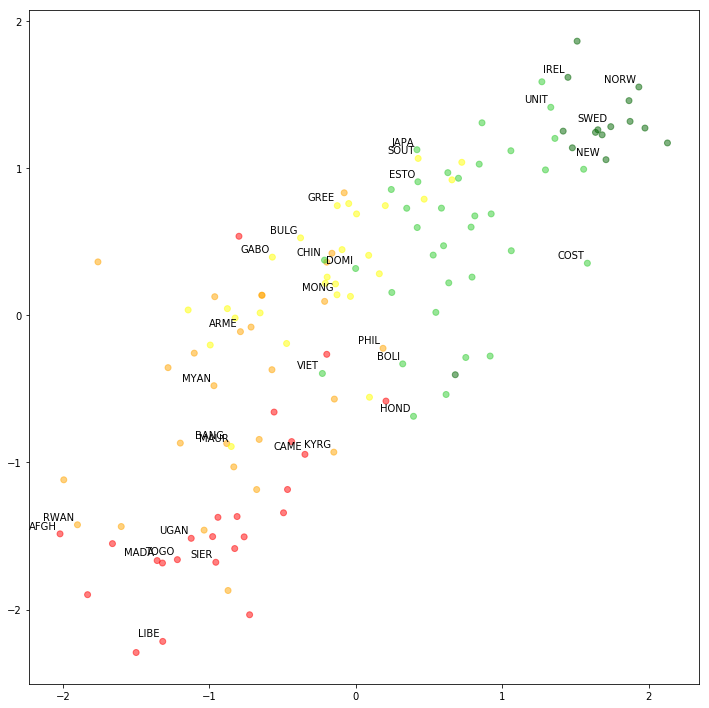

In [16]:
import numpy as np
import matplotlib.pyplot as plt

LABEL_COLOR_MAP = {0 : "red", 1: "orange", 2: "yellow", 3: "limegreen", 4: "darkgreen" }
label_color = [LABEL_COLOR_MAP[l] for l in cpd['Cluster']]

plt.figure(figsize=(12, 12))  # set size of overall figure
plt.subplots_adjust(bottom=0.1) 
plt.scatter(cpd['HappinessScore'], cpd['LogGDP'],label=cpd['Country'], c = label_color, alpha=0.5)

# Label data points with their letters
cnt = 0
for label, x, y in zip(countries, cpd.loc[:, 'HappinessScore'], cpd.loc[:, 'LogGDP']):
    if (cnt % 4) == 0:
        plt.annotate(
            label,  # what label to place
            xy=(x, y),  # where the point is (actual coordinates)
            xytext=(-3, 3),  # where the characters should start (pixels)
            textcoords='offset points',  # use the xytext offsets to place text
            ha='right',  # horizontal alignment of text
        #         va='bottom'
            va='bottom')  # vertical alignment of text
    cnt += 1


### Happiness-Score vs. Social-Support

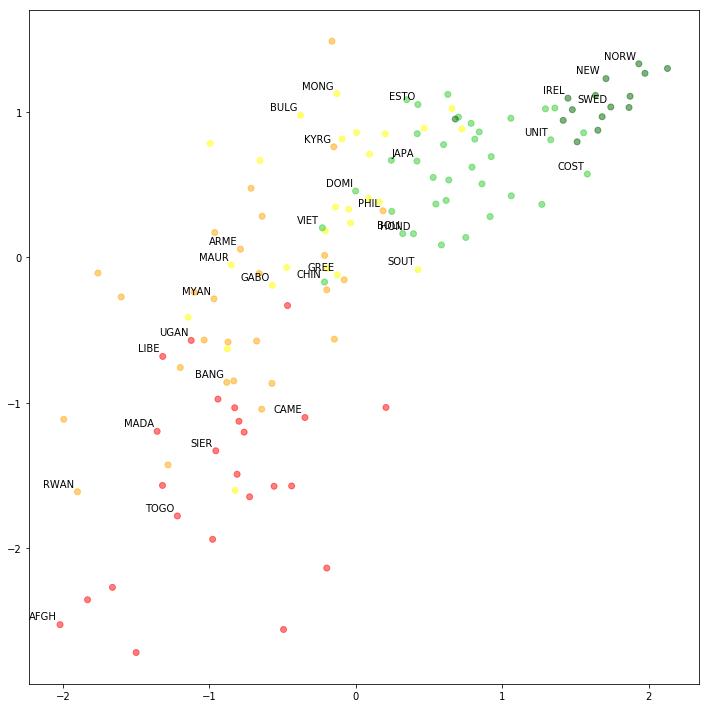

In [17]:
import numpy as np
import matplotlib.pyplot as plt

LABEL_COLOR_MAP = {0 : "red", 1: "orange", 2: "yellow", 3: "limegreen", 4: "darkgreen" }
label_color = [LABEL_COLOR_MAP[l] for l in cpd['Cluster']]

plt.figure(figsize=(12, 12))  # set size of overall figure
plt.subplots_adjust(bottom=0.1) 
plt.scatter(cpd['HappinessScore'], cpd['SocialSupport'],label=cpd['Country'], c = label_color, alpha=0.5)

# Label data points with their letters
cnt = 0
for label, x, y in zip(countries, cpd.loc[:, 'HappinessScore'], cpd.loc[:, 'SocialSupport']):
    if (cnt % 4) == 0:
        plt.annotate(
            label,  # what label to place
            xy=(x, y),  # where the point is (actual coordinates)
            xytext=(-3, 3),  # where the characters should start (pixels)
            textcoords='offset points',  # use the xytext offsets to place text
            ha='right',  # horizontal alignment of text
        #         va='bottom'
            va='bottom')  # vertical alignment of text
    cnt += 1


### Happiness-Score vs. Healthy-Life-Expectancy-At-Birth

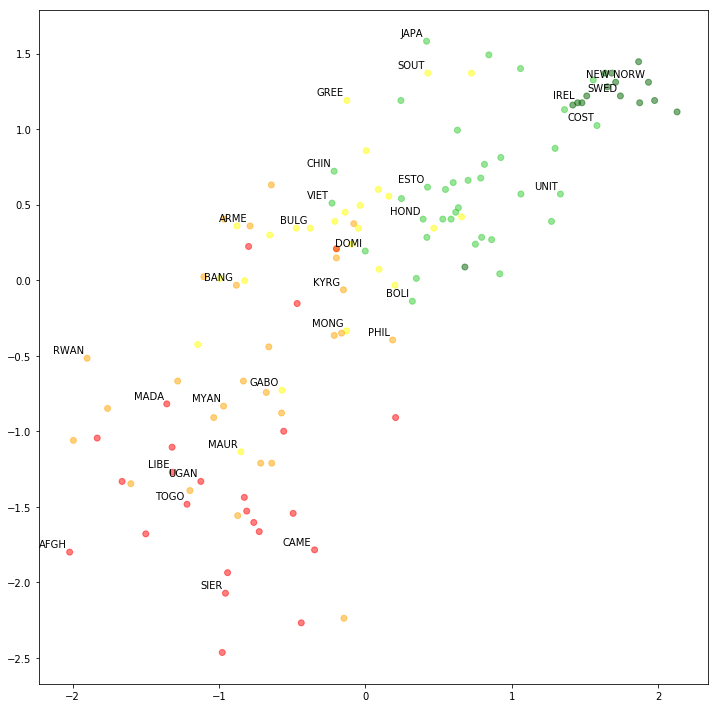

In [18]:
import numpy as np
import matplotlib.pyplot as plt

LABEL_COLOR_MAP = {0 : "red", 1: "orange", 2: "yellow", 3: "limegreen", 4: "darkgreen" }
label_color = [LABEL_COLOR_MAP[l] for l in cpd['Cluster']]

plt.figure(figsize=(12, 12))  # set size of overall figure
plt.subplots_adjust(bottom=0.1) 
plt.scatter(cpd['HappinessScore'], cpd['HealthyLifeExpectancyAtBirth'],label=cpd['Country'], c = label_color, alpha=0.5)

# Label data points with their letters
cnt = 0
for label, x, y in zip(countries, cpd.loc[:, 'HappinessScore'], cpd.loc[:, 'HealthyLifeExpectancyAtBirth']):
    if (cnt % 4) == 0:
        plt.annotate(
            label,  # what label to place
            xy=(x, y),  # where the point is (actual coordinates)
            xytext=(-3, 3),  # where the characters should start (pixels)
            textcoords='offset points',  # use the xytext offsets to place text
            ha='right',  # horizontal alignment of text
        #         va='bottom'
            va='bottom')  # vertical alignment of text
    cnt += 1


### Happiness-Score vs. Perceptions-Of-Corruption

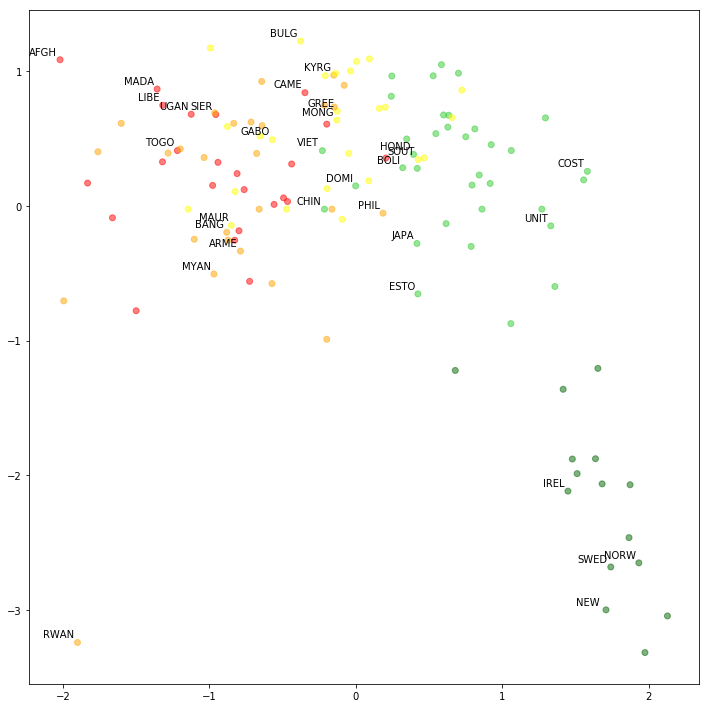

In [15]:
import numpy as np
import matplotlib.pyplot as plt

LABEL_COLOR_MAP = {0 : "red", 1: "orange", 2: "yellow", 3: "limegreen", 4: "darkgreen" }
label_color = [LABEL_COLOR_MAP[l] for l in cpd['Cluster']]

plt.figure(figsize=(12, 12))  # set size of overall figure
plt.subplots_adjust(bottom=0.1) 
plt.scatter(cpd['HappinessScore'], cpd['PerceptionsOfCorruption'],label=cpd['Country'], c = label_color, alpha=0.5)

# Label data points with their letters
cnt = 0
for label, x, y in zip(countries, cpd.loc[:, 'HappinessScore'], cpd.loc[:, 'PerceptionsOfCorruption']):
    if (cnt % 4) == 0:
        plt.annotate(
            label,  # what label to place
            xy=(x, y),  # where the point is (actual coordinates)
            xytext=(-3, 3),  # where the characters should start (pixels)
            textcoords='offset points',  # use the xytext offsets to place text
            ha='right',  # horizontal alignment of text
        #         va='bottom'
            va='bottom')  # vertical alignment of text
    cnt += 1


### By visual inspection, how correlated is the happiness score with each parameter?




By visual inspection, happiness score is strongly & positively correlated to the first 3 parameters and strongly & negatively correlated to the last parameter.